In [79]:
# Some jupyter magic to set up the environment correctly
%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import calendar
import collections
import requests

import time
import json
import os

store = pd.HDFStore('data_cache/blocking_probes.h5')

In [2]:
# UDP blocking probes from 2015 measurements
udp_blocking_2015 = \
np.array([   637.,    689.,    720.,   1004.,   1121.,   1270.,   2577.,
         2601.,   2844.,   2975.,   3021.,   3174.,   3730.,   4298.,
         4554.,   4720.,   4776.,   4833.,   4886.,  10212.,  10977.,
        11055.,  12289.,  13061.,  13240.,  13442.,  13712.,  13928.,
        14115.,  14390.,  14398.,  14419.,  14454.,  14593.,  14797.,
        14889.,  14998.,  15261.,  15342.,  15743.,  15782.,  15942.,
        15946.,  15955.,  16053.,  16414.,  16845.,  17009.,  17455.,
        17855.,  17938.,  18044.,  18182.,  18292.,  18354.,  18387.,
        18550.,  18648.,  19002.,  19201.,  19583.,  19656.,  19774.,
        19898.,  19953.,  19998.,  20105.,  20404.,  20423.,  20427.,
        20456.,  20479.,  20796.,  20861.,  21170.,  21903.,  22361.,
        22471.,  22667.,  22694.,  22948.,  23236.]).astype(int)

In [3]:
# UDP blocking probes from Emile's MTU measurements
udp_blocking_mar16 = \
np.array([    58.,     79.,    280.,    299.,    506.,    584.,    675.,
          679.,    817.,    843.,    861.,    892.,    980.,    996.,
         1004.,   1396.,   2087.,   2093.,   2162.,   2175.,   2235.,
         2237.,   2282.,   2333.,   2577.,   2690.,   2751.,   2792.,
         2844.,   2903.,   2906.,   2975.,   3004.,   3013.,   3083.,
         3156.,   3174.,   3216.,   3229.,   3280.,   3293.,   3303.,
         3370.,   3379.,   3457.,   3620.,   3639.,   3791.,   3828.,
         3831.,   3879.,   3906.,   4066.,   4072.,   4127.,   4151.,
         4203.,   4214.,   4270.,   4498.,   4554.,   4699.,   4776.,
         4814.,   4833.,   4875.,   4903.,   4965.,  10058.,  10212.,
        10250.,  10639.,  10915.,  11020.,  11056.,  11119.,  11232.,
        11359.,  11383.,  11410.,  11483.,  11530.,  11619.,  11802.,
        11832.,  11916.,  11978.,  11995.,  12050.,  12053.,  12402.,
        12778.,  12835.,  12880.,  12888.,  12974.,  12983.,  13051.,
        13061.,  13214.,  13219.,  13381.,  13442.,  13542.,  13558.,
        13633.,  13635.,  13742.,  13882.,  13928.,  13978.,  14273.,
        14376.,  14419.,  14450.,  14454.,  14635.,  14695.,  14847.,
        14877.,  14922.,  15037.,  15049.,  15063.,  15074.,  15252.,
        15261.,  15554.,  15625.,  15646.,  15743.,  15762.,  15817.,
        15862.,  15903.,  15942.,  15946.,  16006.,  16090.,  16106.,
        16216.,  16544.,  16548.,  16669.,  16689.,  16723.,  16759.,
        16821.,  16856.,  16958.,  17138.,  17176.,  17244.,  17428.,
        17505.,  17572.,  17807.,  17855.,  17895.,  17906.,  17917.,
        18000.,  18110.,  18148.,  18165.,  18243.,  18263.,  18273.,
        18296.,  18300.,  18344.,  18387.,  18627.,  18681.,  18695.,
        18697.,  18723.,  18904.,  18907.,  18984.,  19002.,  19055.,
        19201.,  19241.,  19298.,  19424.,  19434.,  19473.,  19505.,
        19569.,  19662.,  19693.,  19807.,  19813.,  19827.,  19898.,
        19953.,  19978.,  20025.,  20138.,  20342.,  20359.,  20400.,
        20404.,  20423.,  20430.,  20456.,  20461.,  20467.,  20476.,
        20488.,  20599.,  20630.,  20636.,  20757.,  20775.,  20777.,
        20843.,  20980.,  21074.,  21093.,  21165.,  21258.,  21320.,
        21351.,  21403.,  21424.,  21580.,  21704.,  21713.,  21726.,
        21764.,  21815.,  21882.,  21985.,  22112.,  22174.,  22510.,
        22568.,  22667.,  22813.,  22834.,  22880.,  22955.,  22991.,
        23012.,  23111.,  23180.,  23207.,  23267.,  23271.,  23272.,
        23281.,  23355.,  23403.,  23419.,  23467.,  23473.,  23749.,
        23857.,  23969.,  23986.,  23987.,  24170.,  24209.,  24268.,
        24310.,  24437.,  24503.,  24522.,  24748.,  24774.,  24826.,
        24891.,  25002.,  25089.,  25100.,  25160.,  25334.,  25377.,
        25595.,  25623.,  25960.,  26313.,  26389.,  26620.,  26774.,
        26808.,  26832.,  26908.,  26960.,  26993.,  27097.,  27320.,
        27325.,  27401.]).astype(int)

In [51]:
# RIPE Atlas anchor IP addresses
anchor_ips = set()
with open("data_cache/anchor-list.txt", mode="r", encoding="utf8") as file:
    for line in file:
        anchor_ips.add(line.rstrip())

In [4]:
def gen_msms_by_pids(pids, 
                 first_start=0, 
                 last_start=calendar.timegm(time.gmtime()), 
                 skip_lines = 0):
    """
    Find all MSM IDs involving the given PIDs in the all-measurements file.
    
    """
    
    matched_msms = set()
    
    with open("data_cache/all-measurements-fjson.txt") as fjf:
        for num, line in enumerate(fjf):
            if num < skip_lines:
                continue
            
            if (num % 100000) == 0:
                print("%u" % (num))
            
            mm = json.loads(line)
            
            # check time window
            if not ((mm['start_time'] >= first_start) and
                    (mm['start_time'] < last_start)):
                continue
                
            # check probe membership
            for probeinf in mm['probes']:
                pid = int(probeinf['id'])
                if pid in pids:
                    msm_id = int(mm['msm_id'])
                    if msm_id not in matched_msms:
                        yield msm_id
                        matched_msms.add(msm_id)
                        break

In [95]:
Alp = collections.namedtuple("Alp", ("time","af","proto","pid","sip","dip","rtt"))

RTT_NONE = 0.0
DATA_CACHE_PATH = 'data_cache'

# def gen_sagan(msm_ary):
#     for a_res in msm_ary:
#         yield sagan.Result.get(a_res)

# def gen_dict(msm_ary):
#     for a_res in msm_ary:
#         yield a_res

def gen_alp(msm_ary):
    for a_res in msm_ary:
        if a_res['type'] == 'ping':
            if "rcvd" in a_res:
                for x in a_res["result"]:
                    rtt = None
                    try: 
                        rtt = float(x)
                    except:
                        try:
                            rtt = float(x['rtt'])
                        except:
                            pass
                    if rtt:
                        yield Alp(int(a_res['timestamp']), a_res['af'], a_res['proto'], 
                                  a_res['prb_id'], a_res['src_addr'], a_res['dst_addr'], rtt)
                    else:
                        try:
                            yield Alp(int(a_res['timestamp']), a_res['af'], a_res['proto'], 
                                      a_res['prb_id'], a_res['src_addr'], a_res['dst_addr'], RTT_NONE)
                        except KeyError:
                            pass

        
        elif a_res['type'] == 'traceroute':
            positive_traceroute = False
            if ('result' in a_res) and ('result' in a_res['result'][-1]):
                for h_res in a_res['result'][-1]['result']:
                    if ('from' in h_res) and ('rtt' in h_res) and (h_res['from'] == a_res['dst_addr']):
                        yield Alp(int(a_res['timestamp']), a_res['af'], a_res['proto'] + '_TR', 
                                  a_res['prb_id'], a_res['src_addr'], a_res['dst_addr'], h_res['rtt'])
                        positive_traceroute = True
                if not positive_traceroute:
                    try:
                        yield Alp(int(a_res['timestamp']), a_res['af'], a_res['proto'] + '_TR', 
                                      a_res['prb_id'], a_res['src_addr'], a_res['dst_addr'], RTT_NONE)
                    except KeyError:
                        pass
                        

        # For HTTP, return each subresult as a separate RTT sample
        elif a_res['type'] == 'http':
            positive_http = False
            for r_res in a_res['result']:
                if ('res' in r_res) and (r_res['res'] < 400):
                    yield Alp(a_res['timestamp'], r_res['af'], 'HTTP', 
                              a_res['prb_id'], r_res['src_addr'], r_res['dst_addr'], r_res['rt'])  
                    positive_http = True
            if not positive_http:
                try:
                    yield Alp(a_res['timestamp'], r_res['af'], 'HTTP', 
                              a_res['prb_id'], r_res['src_addr'], r_res['dst_addr'], RTT_NONE)                 
                except KeyError:
                    pass
        

def get_msm(msm, gen=gen_alp, cachedir=None, start=None, stop=None):
    """
    Given an MSM, fetch it from the cache or from the RIPE Atlas API.
    Yield each separate result according to the generation function.
    """
    url = "https://atlas.ripe.net/api/v1/measurement/%u/result/" % (msm,)

    params = {"format": "json"}
    if start is not None and stop is not None:
        params["start"] = str(start)
        params["stop"] = str(stop)
    
    if cachedir and os.path.isdir(cachedir):
        filepath = os.path.join(cachedir, "measurement", "%u.json" % (msm,))

        # download if not present
        if not os.path.isfile(filepath):
            with open(filepath, mode="wb") as file:
                print("Cache miss, retrieving "+url)
                res = requests.get(url, params=params)

                if not res.ok:
                    raise "Atlas measurement API request failed: "+repr(res.json())
                
                file.write(res.content)

        # then read from cache
        try:
            with open(filepath) as stream:
                yield from gen(json.loads(stream.read()))
        except Exception as e:
            print("exception on cache read: "+repr(e))
            

    else:
        # just read from the net
        res = requests.get(url, params=params)
        yield from gen(json.loads(res.content.decode("utf-8")))
        
def get_msms(msms, gen=gen_alp, cachedir=None, start=None, stop=None):
    for msm in msms:
        yield from get_msm(msm, gen, cachedir, start, stop)
        

def latency_dataframe(msm_ids, start=None, stop=None, cachedir=None, 
                      pid_set=None, invert_pid_set=False, chunksize=1000000, max_records=None):
    # initialize MPM generator
    alpgen = get_msms(msm_ids, gen=gen_alp, start=start, stop=stop, cachedir=cachedir)
    
    # initialize accumulators
    df = pd.DataFrame([], columns=Alp._fields)
    data = []
    chunk_count = 0
    record_count = 0
    
    # get individual rows from get_msm
    for alp in alpgen:
        if (pid_set is not None):
            if (((invert_pid_set is False) and (alp.pid not in pid_set)) or
               ((invert_pid_set is True) and (alp.pid in pid_set))):
                continue
            
        data.append(alp)
        
        if len(data) >= chunksize:
            df = df.append(pd.DataFrame(data, columns=Alp._fields), ignore_index=True)
            data = []
            print("chunk "+str(chunk_count))
            chunk_count += 1

        record_count += 1
        if max_records and (record_count >= max_records):
            break
           
    # Append final dataframe if non-empty.
    if len(data) > 0:
        df = df.append(pd.DataFrame(data, columns=Alp._fields), ignore_index=True)

    # Close generator (close underlying file)
    alpgen.close()
    
    # Return dataframe
    return df

In [91]:
def plot_ecdf(a, **kwargs):
    sa = np.sort(a)
    yv = np.arange(len(sa))/float(len(sa))
    plt.plot(sa, yv, **kwargs)

In [10]:
%%time 
msms_4q_2015 = [x for x in gen_msms_by_pids(set(udp_blocking_2015), 
                                first_start=calendar.timegm((2015,10,1,0,0,0)),
                                last_start=calendar.timegm((2016,1,1,0,0,0)))]
with open("data_cache/msms_4q_2015.txt", mode="w") as file:
    for msm in msms_4q_2015:
        file.write(str(msm) + "\n")

0
100000
200000
300000
400000
500000
600000
700000
800000
900000
1000000
1100000
1200000
1300000
1400000
1500000
1600000
1700000
1800000
1900000
2000000
CPU times: user 5min 14s, sys: 11.2 s, total: 5min 25s
Wall time: 5min 31s


In [19]:
with open("data_cache/msms_4q_2015.txt") as file:
    msms_4q_2015 = []
    for line in file:
        msms_4q_2015.append(int(line))

In [20]:
len(msms_4q_2015)

38073

In [22]:
df = latency_dataframe(msms_4q_2015, 
                       pid_set = set(udp_blocking_2015),
                       cachedir="data_cache",
                       max_records=2000000)
store['df'] = df

exception on cache read: JSONDecodeError('Expecting value: line 1 column 1 (char 0)',)
exception on cache read: JSONDecodeError('Expecting value: line 1 column 1 (char 0)',)
exception on cache read: JSONDecodeError('Expecting value: line 1 column 1 (char 0)',)
exception on cache read: JSONDecodeError('Expecting value: line 1 column 1 (char 0)',)
chunk 0
chunk 1


In [109]:
dfop = latency_dataframe(msms_4q_2015,
                                    pid_set = set(udp_blocking_2015),
                                    invert_pid_set = True,
                                    cachedir="data_cache",
                                    max_records=10000000)
store['df_other_probes'] = dfop

chunk 0
chunk 1
chunk 2
chunk 3
chunk 4
chunk 5
chunk 6
chunk 7
chunk 8
chunk 9


In [55]:
df = store['df']

In [110]:
df["success"] = df["rtt"] > 0
df["n"] = 1
dfop["success"] = dfop["rtt"] > 0
dfop["n"] = 1

In [111]:
anchor_df = df[df['dip'].isin(anchors)]
anchor_dfop = df_other_probes[df_other_probes['dip'].isin(anchors)]

True     962647
False     19263
Name: success, dtype: int64

In [58]:
anchor_df["success"] = anchor_df["rtt"] > 0

/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [112]:
anchor_dfop["proto"].value_counts()

ICMP_TR    695545
ICMP       286365
Name: proto, dtype: int64

In [105]:
pp_ok = anchor_df.groupby(["pid","proto"])["success"].sum() / anchor_df.groupby(["pid","proto"])["n"].sum()
ppop_ok = anchor_dfop.groupby(["pid","proto"])["success"].sum() / anchor_dfop.groupby(["pid","proto"])["n"].sum()

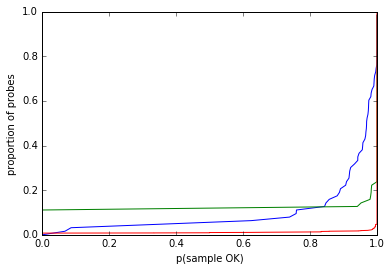

In [115]:
plot_ecdf(pp_ok.xs("HTTP", level="proto"))
plot_ecdf(pp_ok.xs("ICMP", level="proto"))
plot_ecdf(ppop_ok.xs("ICMP", level="proto"))

plt.xlabel("p(sample OK)")
plt.ylabel("proportion of probes")
